In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use("https://github.com/mlefkir/beauxgraphs/raw/main/beautifulgraphs_colblind.mplstyle")

# Timmer and Koenig's method

We follow the method described in [Timmer & Koenig (1995)](https://ui.adsabs.harvard.edu/abs/1995A%26A...300..707T). 

## Description of the method

### Main idea

1. Evaluate the power spectral density at a set of frequencies $f_j$ to get a set of power values $P_j=\mathcal{P}(f_j)$
2. Draw two random numbers $N_{1,j}$ and $N_{2,j}$ from a standard normal distribution for each frequency $f_j$.
3. Calculate the complex Fourier coefficients $A_j=\sqrt{P_j/2} \left (N_{1,j}+\mathrm{i}N_{2,j} \right)$. Where $A_0=0$ so that the mean of the time series is zero and the last value $A_j$ is a real number.
4. Calculate the inverse Fourier transform of the coefficients $A_j$ to get a realisation of the time series $x(t)$.

### Extending the frequency grid

To reduce the effects of aliasing and leakage in the generated time series we extend the frequency grid with two factors: $S_\mathrm{low}$ and $S_\mathrm{high}$, for low and high frequencies, respectively. The grid of frequencies is then given by $f_0 = f_\mathrm{min}/S_\mathrm{low} = \Delta f$ to $f_N = f_\mathrm{max}S_\mathrm{high}$.

```{eval-rst}
.. tikz:: 
    :xscale: 90

    [thick]

    \draw (0,2pt) -- + (0,-2pt) node[below=1mm] {0};
    \draw (.5,2pt) -- + (0,-2pt) node[below=1mm] {$f_0$};
    \draw (3.5,5pt) -- + (0,-5pt) node[below=1mm] {$f_\mathrm{min}$};
    \draw (10.,5pt) -- + (0,-5pt) node[below=1mm] {$f_\mathrm{max}$};
    \draw (14,5pt) -- + (0,-5pt) node[below=1mm] {$f_\mathrm{N}$};
    \draw[thick] (0,0) -- node[below=7mm] {Frequency $f$} + (15,0);
    \foreach \x in {0,0.5,...,14.}
       \draw (\x cm,3pt) -- (\x cm,-3pt) node[anchor=north] {};
```

The generated time series will be longer than the desired time series, to obtain a time series of duration $T$ with sampling period $\Delta T$, a random subset of the long time is selected. The subset is then resampled to the desired sampling period $\Delta T$.

The true variance of the process is given by $\int_{-\infty}^{+\infty} \mathcal{P}(f) \mathrm{d}f$. To correct for the variance of the generated time series, we multiply the time series by a factor $2\sqrt{f_0}N$. More details about the sample variance of time series are given [here](On_the_sample_variance.ipynb).

### Implementation in `pioran`

The main method is implemented in the {meth}`~pioran.simulate.Simulations.timmer_Koenig_method` method of the class {class}`~pioran.simulate.Simulations`. This method is used to generate the long-term time series. Then a random subset is selected and resampled to the desired sampling period using the {meth}`~pioran.simulate.Simulations.extract_subset_timeseries` and {meth}`~pioran.simulate.Simulations.sample_timeseries` methods. This is done under the hood by the {meth}`~pioran.simulate.Simulations.simulate` method, which we detail in the next section.

## Usage in `pioran`

The first thing to do is to define the parameters of the time series, duration, sampling and PSD model and the parameters of the method which are scaling factors for the frequency grid.
All of these are given to the initialisation of a {class}`~pioran.simulate.Simulations` object.

In [3]:
from pioran import Simulations
from pioran.psd import Lorentzian

psd_model = Lorentzian([0,1,1e-2])

duration = 400
sample_period = 1.5
S_low = 20 # scale of the lowest frequency
S_high = 20 # scale of the highest frequency
Sim = Simulations(T=duration,dt=sample_period,model=psd_model,S_low=S_low,S_high=S_high)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


We can plot the PSD model to see what it looks like.

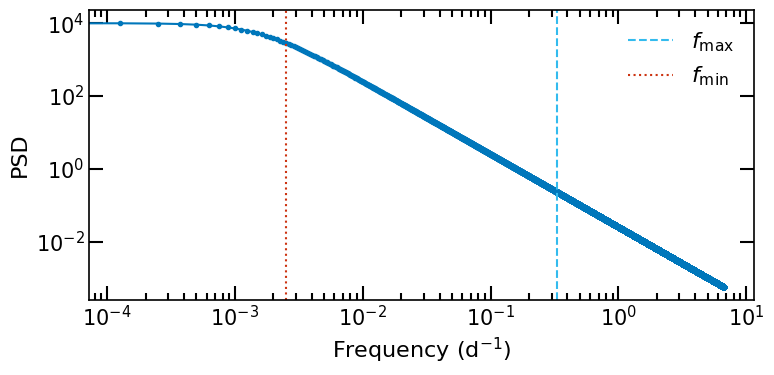

In [4]:
fig,ax = Sim.plot_psd(figsize=(8,4))

To generate a random time series we use the {meth}`~pioran.simulate.Simulations.simulate` method. We specify the method to use with `method='TK'`. By default, the values of the time series are randomised with a normal distribution. This can be changed with the `randomise_fluxes` argument. The errors are assumed to be Gaussian.

By default, the mean of the time series is shifted to twice the minimum of the time series to get a positive-valued time series. This can be changed with the `mean` argument. 

The sampling can be selected as irregular with the `irregular_sampling` argument. The seed of the random number generator must be set with the `seed` argument.

In [5]:
t, ts, ts_err = Sim.simulate(method='TK',seed=1423,irregular_sampling=True)

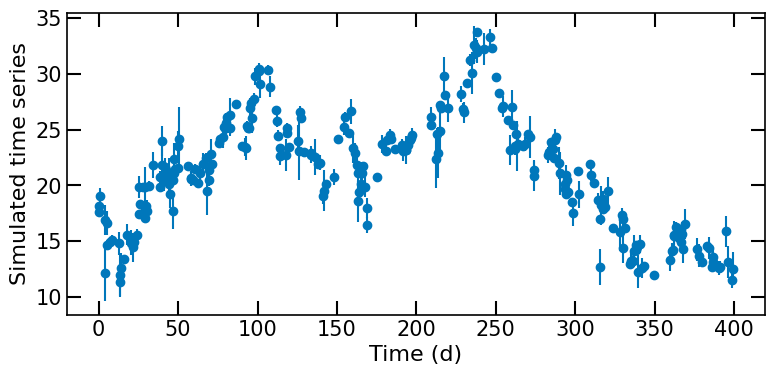

In [6]:
fig, ax = plt.subplots(figsize=(8,4))
ax.errorbar(t,ts,yerr=ts_err,fmt='o')
ax.set_xlabel('Time (d)')
ax.set_ylabel('Simulated time series')
fig.tight_layout()

## References

Timmer J. & Koenig M. On generating power law noise. Astronomy and Astrophysics, [300](https://ui.adsabs.harvard.edu/abs/1995A%26A...300..707T), 707 (1995). 